In [1]:
import numpy as np
import matplotlib
import matplotlib.colors as mplcolors
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import sys


def random_mpl_color_rgb():
    return (np.random.uniform(), np.random.uniform(), np.random.uniform())


def random_mpl_color_rgba(alpha=0.25):
    rgba_tup = random_mpl_color_rgb() + (alpha,)
    return rgba_tup


def random_mpl_color_rgb_rgba(alpha=0.25):
    """
    generate a pair of rgb and rgba color, both of them have same R G B value.
    """
    rgb_tup = random_mpl_color_rgb()
    rgba_tup = rgb_tup + (alpha,)
    return rgb_tup, rgba_tup


class Boite:
    def __init__(self, point_ref, longeur, largeur, hauteur):
        assert isinstance(point_ref, tuple)
        assert len(point_ref) == 3
        self.x = point_ref[0]
        self.y = point_ref[1]
        self.z = point_ref[2]
        self.longeur = longeur
        self.largeur = largeur
        self.hauteur = hauteur

        # fristly we think the reference point is at the origin
        self._temp_sommets = np.array([[-longeur / 2.0, -largeur / 2.0, -hauteur / 2.0],
                                       [longeur / 2.0, -largeur / 2.0, -hauteur / 2.0],
                                       [longeur / 2.0, largeur / 2.0, -hauteur / 2.0],
                                       [-longeur / 2.0, largeur / 2.0, -hauteur / 2.0],
                                       [-longeur / 2.0, -largeur / 2.0, hauteur / 2.0],
                                       [longeur / 2.0, -largeur / 2.0, hauteur / 2.0],
                                       [longeur / 2.0, largeur / 2.0, hauteur / 2.0],
                                       [-longeur / 2.0, largeur / 2.0, hauteur / 2.0]])

    def translation(self, length_x, length_y, length_z):
        self.x = self.x + length_x
        self.y = self.y + length_y
        self.z = self.z + length_z

    def rotation3d(self, alpha, beta, gamma):
        """
        :param alpha: perform a rotation about x axis
        :param beta: perform a rotation about y axis
        :param gamma: perform a rotation about z axis
        :return:
        """
        rx = np.array([[1, 0, 0],
                       [0, np.cos(alpha), -np.sin(alpha)],
                       [0, np.sin(alpha), np.cos(alpha)]])
        ry = np.array([[np.cos(beta), 0, np.sin(beta)],
                       [0, 1, 0],
                       [-np.sin(beta), 0, np.cos(beta)]])
        rz = np.array([[np.cos(gamma), -np.sin(gamma), 0],
                       [np.sin(gamma), np.cos(gamma), 0],
                       [0, 0, 1]])
        self._temp_sommets = np.transpose(rz.dot(ry.dot(rx.dot(np.transpose(self._temp_sommets)))))
        self._update_verts()

    def _update_sommets(self):
        # after some operation we need to translate object to real location.
        self.sommets = np.ones((self._temp_sommets.shape[0], 1)) * np.array(
            [self.x, self.y, self.z]) + self._temp_sommets

    def _update_verts(self):
        # obtain all surfaces.
        self._update_sommets()
        self.verts = [[self.sommets[0], self.sommets[1], self.sommets[2], self.sommets[3]],
                      [self.sommets[4], self.sommets[5], self.sommets[6], self.sommets[7]],
                      [self.sommets[0], self.sommets[1], self.sommets[5], self.sommets[4]],
                      [self.sommets[2], self.sommets[3], self.sommets[7], self.sommets[6]],
                      [self.sommets[1], self.sommets[2], self.sommets[6], self.sommets[5]],
                      [self.sommets[4], self.sommets[7], self.sommets[3], self.sommets[0]]]

    def getVerts(self):
        self._update_verts()
        return self.verts

    def getSommets(self):
        self._update_sommets()
        return self.sommets

    def getPoly3d(self, facecolors=None, edgecolors=None):
        if facecolors == None and edgecolors == None:
            edgecolors, facecolors = random_mpl_color_rgb_rgba()
        elif facecolors == None and edgecolors != None:
            if isinstance(edgecolors, str):
                edgecolors = mplcolors.to_rgb(edgecolors)
            assert isinstance(edgecolors, tuple)
            facecolors = (edgecolors[0], edgecolors[1], edgecolors[2]) + (0.25,)
        elif edgecolors == None and facecolors != None:
            if isinstance(facecolors, str):
                facecolors = mplcolors.to_rgb(facecolors)
            assert isinstance(facecolors, tuple)
            edgecolors = (facecolors[0], facecolors[1], facecolors[2])
        self._update_verts()
        poly3d = Poly3DCollection(self.verts,
                                  facecolors=facecolors, linewidths=1, edgecolors=edgecolors)
        return poly3d


class Camion(Boite):
    def __init__(self, point_ref, longeur, largeur, hauteur):
        super().__init__(point_ref, longeur, largeur, hauteur)

    @classmethod
    def atOrigine(cls, longeur, largeur, hauteur):
        return cls((longeur / 2.0, largeur / 2.0, hauteur / 2.0), longeur, largeur, hauteur)

    def init(self, camion_color=(1, 1, 1, 0), edgecolors="black"):
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111, projection="3d")
        self.ax1.set_aspect(1)
        self.ax1.add_collection3d(super().getPoly3d(facecolors=camion_color, edgecolors=edgecolors))

    def addPoly3d(self, poly3d):
        self.ax1.add_collection3d(poly3d)

    def draw(self, show_axis=False, show_axis_label=False, show_grid=False):
        axis_switch = "on" if show_axis else "off"
        plt.axis(axis_switch)
        if show_axis_label == True:
            self.ax1.set_xlabel("X")
            self.ax1.set_ylabel("Y")
            self.ax1.set_zlabel("Z")
        self.ax1.grid(show_grid)
        plt.show()


#####################################################################
def overlap2d(center_1, length_1, width_1, center_2, length_2, width_2):
    overlap_length = max(0, min(center_1[0] + length_1/2, center_2[0]+length_2/2) -
                        max(center_1[0] - length_1/2, center_2[0] - length_2/2))
    overlap_width = max(0, min(center_1[1] + width_1/2, center_2[1]+width_2/2) -
                        max(center_1[1] - width_1/2, center_2[1] - width_2/2))
    overlap_area = overlap_length * overlap_width
    ret = False
    if overlap_area != 0:
        ret = True
    return ret, overlap_area, overlap_length, overlap_width

def addGravity(X, B):
    X_copy = X.copy()
    z_set = set(X_copy[:, 2])
    placement_order = []
    while (len(z_set) != 0):
        lowest_z = min(z_set)
        idx = X_copy[:, 2] == lowest_z
        msg_str = []
        for i, j in enumerate(list(idx)):
            if j == True:
                msg_str.append(i)
        # print("lowest z: {}, Number of lowest composant: {}".format(lowest_z, msg_str))
        placement_order.extend(msg_str)
        z_set.remove(lowest_z)

    # print("Placement order: ", placement_order)

    placed_list = []
    for composant_i in placement_order:
        # print("considering composant i >>> {} ...".format(composant_i))
        # print(placed_list)
        z_last_composant = 0
        if len(placed_list) != 0:
            overlap_list = []
            for composant_j in placed_list:
                # print("--composant j >>> {}".format(composant_j))
                ret, _, overlap_length, overlap_width = overlap2d(X_copy[composant_i], B[composant_i, 0], B[composant_i, 1],
                                   X_copy[composant_j], B[composant_j, 0], B[composant_j, 1])
                if (ret and overlap_length>0.1 and overlap_width >0.1):
                    overlap_list.append(composant_j)
            # print("overlap_list: {}".format(overlap_list))
            if len(overlap_list) == 0:
                z_last_composant = 0
            else:
                z_last_composant = np.max(X_copy[overlap_list, 2] + B[overlap_list, 2] / 2)
        z_i = B[composant_i, 2] / 2 + z_last_composant
        # print("z_i: ", z_i)
        X_copy[composant_i, 2] = z_i

        placed_list.append(composant_i)
    return X_copy

## Visualize un agencement

<IPython.core.display.Javascript object>


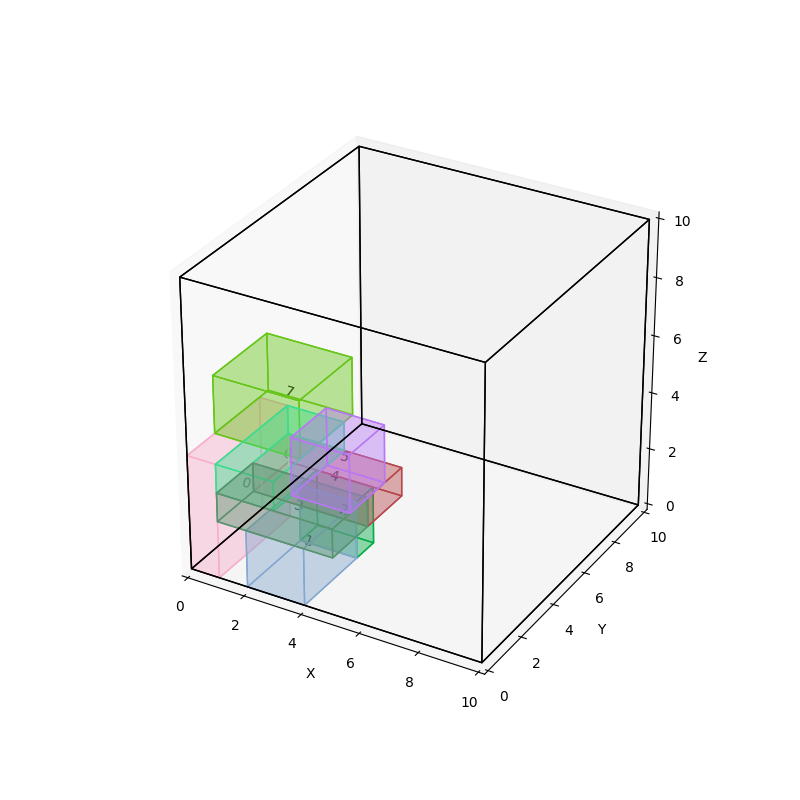

In [2]:
X = np.array([[0.5, 2, 2], [3, 1.5, 1], [3,3.5, 1], [3,1,2.5], [3,3,2.5], [4, 2,4], [2,2,3.5], [1.5,3, 5]]).astype(float)
B = np.array([[1, 4, 4], [2, 3, 2], [2,1,2], [4, 2,1], [4,2,1], [2,2,2], [2,4,1], [3,3, 2]]).astype(float)
C = np.array([10,10,10])
X = addGravity(X,B)
nb_composant = X.shape[0]
%matplotlib notebook
boite_color_list = []
for i in range(nb_composant):
    boite_color_list.append(random_mpl_color_rgba())

camion = Camion.atOrigine(C[0], C[1], C[2]);
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111, projection="3d")    
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")
ax1.set_xlim(-0, C[0])
ax1.set_ylim(-0, C[1])
ax1.set_zlim(-0, C[2])
ax1.grid(False)
ax1.add_collection3d(camion.getPoly3d(facecolors=(1, 1, 1, 0), edgecolors="black"))
boite_list = []
for i in range(X.shape[0]):
    boite = Boite((X[i, 0], X[i, 1], X[i, 2]), B[i, 0], B[i, 1], B[i, 2])
    boite_list.append(boite)
    ax1.add_collection3d(boite.getPoly3d(facecolors=boite_color_list[i]))
    ax1.text(*X[i, :], str(i), 'x')
plt.show()

## Obtenir l'ordre de dechargement actuel 

In [3]:
def get_dechargement_order(X, B, direction="-x", len_ignore=0):
    """
    direction: `+x` and `x` means we will take out items at the left side, 
    -x means we will take out items at the far right side 
    `+y` and `y` means we will take out items at the front side 
    -y means we will take out items at the reverse side
    """
    X_copy = X.copy().astype(float)
    if direction == "-x":
        max_flag = True
        axis = 0 
    elif direction == "+x" or direction == "x":
        max_flag = False 
        axis = 0 
    elif direction =="-y":
        max_flag = True 
        axis = 1
    elif direction == "+y"  or direction == "y":
        max_flag = False 
        axis = 1
    elif direction == "-z":
        max_flag = True 
        axis = 2
    else:
        raise Exception("Invalid direction '{}'.".format(direction))
        
        
    if max_flag:
        surface_position = X_copy[:, axis] + B[:, axis]/2.0
    else:
        surface_position = X_copy[:, axis] - B[:, axis]/2.0
        
    values_set = set(surface_position)
    raw_dechargement_order = []
    while (len(values_set) != 0):
        if max_flag == True:
            value_chosen = max(values_set)
        else:
            value_chosen = min(values_set)
        idx = surface_position == value_chosen
        items_same_position = []
        for i, j in enumerate(list(idx)):
            if j == True:
                items_same_position.append(i)
        raw_dechargement_order.extend(items_same_position)
        values_set.remove(value_chosen)

    print("\nraw dechargement order: ", raw_dechargement_order)

    dechargement_order = []
    while(len(raw_dechargement_order) != 0):
        for composant_i in raw_dechargement_order:
            print("considering composant i >>> {} ...".format(composant_i))
            other_composants = raw_dechargement_order.copy() 
            other_composants.remove(composant_i)

            remove_flag = True 
            for composant_j in other_composants:

                print("considering composant j >>> {} ...".format(composant_j))
                ret, _, overlap_length, overlap_width = overlap2d(
                    X_copy[composant_i], B[composant_i, 0], B[composant_i, 1],
                    X_copy[composant_j], B[composant_j, 0], B[composant_j, 1])
                if ret and overlap_length>len_ignore and overlap_length>len_ignore:
                    if (X_copy[composant_j, 2]>X_copy[composant_i, 2]):
                        # composant j on the top of composant i, we cannot remove composant i
                        remove_flag = False
                        break 
            if(remove_flag):
                print("We can remove composant {}".format(composant_i))
                dechargement_order.append(composant_i)
                raw_dechargement_order.remove(composant_i)
                break 
            else:
                print("We cannot remove composant {}".format(composant_i))
        
    
    print("\ndechargement order: {}".format(dechargement_order))

    return dechargement_order


In [4]:
raw_dechargement_order = get_dechargement_order(X, B, direction="-x")


raw dechargement order:  [3, 4, 5, 1, 2, 6, 7, 0]
considering composant i >>> 3 ...
considering composant j >>> 4 ...
considering composant j >>> 5 ...
We cannot remove composant 3
considering composant i >>> 4 ...
considering composant j >>> 3 ...
considering composant j >>> 5 ...
We cannot remove composant 4
considering composant i >>> 5 ...
considering composant j >>> 3 ...
considering composant j >>> 4 ...
considering composant j >>> 1 ...
considering composant j >>> 2 ...
considering composant j >>> 6 ...
considering composant j >>> 7 ...
considering composant j >>> 0 ...
We can remove composant 5
considering composant i >>> 3 ...
considering composant j >>> 4 ...
considering composant j >>> 1 ...
considering composant j >>> 2 ...
considering composant j >>> 6 ...
We cannot remove composant 3
considering composant i >>> 4 ...
considering composant j >>> 3 ...
considering composant j >>> 1 ...
considering composant j >>> 2 ...
considering composant j >>> 6 ...
We cannot remove com

In [5]:
print(raw_dechargement_order)

[5, 7, 6, 3, 4, 1, 2, 0]


## Ordre de dechargement ideal 

In [6]:
def read_dechargement_order_csv(csv_file):
    """

    :param csv_file: csv file which save dechargement order
    :return: enterprise order, dechargement order, entreprise_item_dict dict
    """
    lines = pd.read_csv(csv_file)

    entreprise_item_dict = {}
    item_entreprise_dict = {}
    entreprise_order = []
    for i, line in lines.iterrows():
        entreprise = line["Entreprise"]
        item = line["Item"]
        if entreprise not in entreprise_order:
            entreprise_order.append(entreprise)
            entreprise_item_dict[entreprise] = []
        entreprise_item_dict[entreprise].append(item)
        item_entreprise_dict[str(item)] = entreprise
    dechargement_order = []
    for entreprise in entreprise_order:
        sub_list = []
        sub_list.extend(entreprise_item_dict[entreprise])
        dechargement_order.append(sub_list)
    return entreprise_order, dechargement_order, entreprise_item_dict, item_entreprise_dict

def print_dechargement_order(entreprise_order, entreprise_item_dict):
    print("Dechargement order: ")
    for entreprise in entreprise_order:
        print("Entreprise '{}': {};".format(entreprise, entreprise_item_dict[entreprise]))

In [7]:
entreprise_order, ideal_dechargement_order, ideal_entreprise_item_dict, ideal_item_entreprise_dict = read_dechargement_order_csv(
                                                    "ideal_dechargement_order.csv")
print_dechargement_order(entreprise_order, ideal_entreprise_item_dict)
print(ideal_dechargement_order)

Dechargement order: 
Entreprise 'A': [3, 4, 5];
Entreprise 'B': [1, 2];
Entreprise 'C': [0, 6, 7];
[[3, 4, 5], [1, 2], [0, 6, 7]]


In [8]:
def split_dechargement_order(raw_list, ideal_order, entreprise_order):
    actual_order = []
    start_pos = 0
    actual_entreprise_item_dict = {}
    actual_item_entreprise_dict = {}
    for i in range(len(ideal_order)):
        entreprise = entreprise_order[i]
        len_slice = len(ideal_order[i])
        sub_list = raw_list[start_pos: start_pos + len_slice]
        # sub_list = sorted(sub_list)
        actual_order.append(sub_list)
        actual_entreprise_item_dict[entreprise] = sub_list
        for item in sub_list:
            actual_item_entreprise_dict[str(item)] = entreprise
        start_pos = start_pos + len_slice
    return actual_order, actual_entreprise_item_dict, actual_item_entreprise_dict

def unpack_dechargement_order(dechargement_order):
    unpacked_dechargement_order = []
    for i in range(len(dechargement_order)):
        unpacked_dechargement_order.extend(dechargement_order[i])
    return unpacked_dechargement_order



def get_entreprise_pos(item, item_entreprise_dict, entreprise_order):
    entreprise_name = item_entreprise_dict[str(item)]
    pos = entreprise_order.index(entreprise_name)
    return pos

def get_dechargement_dist(actual_order, actual_item_entreprise_dict,
                          actual_entreprise_item_dict,
                          ideal_order, ideal_item_entreprise_dict,
                          entreprise_order):
    unpack_actual_order = unpack_dechargement_order(actual_order)
    unpack_ideal_order = unpack_dechargement_order(ideal_order)
    dist = 0

    for i, item in enumerate(unpack_ideal_order):
        pos_ideal = get_entreprise_pos(item, ideal_item_entreprise_dict, entreprise_order)
        pos_actual = get_entreprise_pos(item, actual_item_entreprise_dict, entreprise_order)
        if pos_actual > pos_ideal:
            actual_entreprise = actual_item_entreprise_dict[str(item)]
            sub_dechargement_list = actual_entreprise_item_dict[actual_entreprise]
            pos_prime = sub_dechargement_list.index(item)

            dist_slice = pos_actual - pos_ideal + pos_prime/len(sub_dechargement_list)
        elif pos_actual < pos_ideal:
            actual_entreprise = actual_item_entreprise_dict[str(item)]
            sub_dechargement_list = actual_entreprise_item_dict[actual_entreprise]
            pos_prime = sub_dechargement_list.index(item)

            dist_slice = pos_ideal - pos_actual + (len(sub_dechargement_list) - pos_prime - 1)/len(sub_dechargement_list)
        else:
            dist_slice = 0
        dist_slice = dist_slice**2
        dist = dist + dist_slice

    return dist



In [9]:

actual_dechargement_order, actual_entreprise_item_dict, actual_item_entreprise_dict = \
    split_dechargement_order(raw_dechargement_order, ideal_dechargement_order, entreprise_order)
text_str = "Ideal_dechargement order: {}\nActual_dechargement_order:{}".format(ideal_dechargement_order,
                                                                               actual_dechargement_order)
print(text_str)
dist = get_dechargement_dist(actual_dechargement_order, actual_item_entreprise_dict,
                             actual_entreprise_item_dict,
                             ideal_dechargement_order, ideal_item_entreprise_dict,
                             entreprise_order)

Ideal_dechargement order: [[3, 4, 5], [1, 2], [0, 6, 7]]
Actual_dechargement_order:[[5, 7, 6], [3, 4], [1, 2, 0]]


In [10]:
print(dist)

15.472222222222225
